# 9. Automated Machine Learning 

This notebook contains some basics for autoML using CapyMOA:

* Implement a custom model selection procedure using CapyMOA.
* Perform hyperparameter optimization, and model selection using CapyMOA's AutoML
  features.

---

In [2]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [ ]:
import contextlib
import io
from capymoa.datasets import Electricity, RBFm_100k
from capymoa.evaluation import prequential_evaluation
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier,
    StreamingRandomPatches,
    LeveragingBagging
)
from capymoa.stream.generator import RandomTreeGenerator, SEA
from capymoa.automl import AutoClass, BanditClassifier, SuccessiveHalvingClassifier, EpsilonGreedy

# Setup the data streams for our experiments:
stream = Electricity()
drift_stream = DriftStream(
    moa_stream=ConceptDriftStream(),
    CLI="""
    -s (generators.AgrawalGenerator -f 1) 
    -d (ConceptDriftStream 
        -s (generators.AgrawalGenerator -f 2)
        -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) 
        -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0)
        -p 20000 -w 0) 
    -p 10000 
    -w 0
""",
)

In [11]:
def print_summary(label: str, results):
    print(
        f"{label.ljust(10)} Cumulative accuracy = {results.accuracy():.2f}, "
        f"wall-clock time: {results.wallclock():.3f}"
    )

## 9.1 Custom Model Selection

In this section we manually define a method to select the best model based on
its accuracy on a given stream. First we define a list of models to be tried
and then we iterate over the stream to train and evaluate each model. The
model with the highest accuracy is selected as the best model.

In [10]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    best_accuracy = 0  # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=stream,
            learner=model,
            window_size=window_size,
            max_instances=max_instances,
        )
        all_results[model] = results
        if results.cumulative.accuracy() > best_accuracy:
            best_accuracy = results.cumulative.accuracy()
            model_b = model

    print_summary(f"Best ({model_b})", all_results[model_b])
    return all_results

Best (StreamingRandomPatches) Cumulative accuracy = 90.56, wall-clock time: 0.754


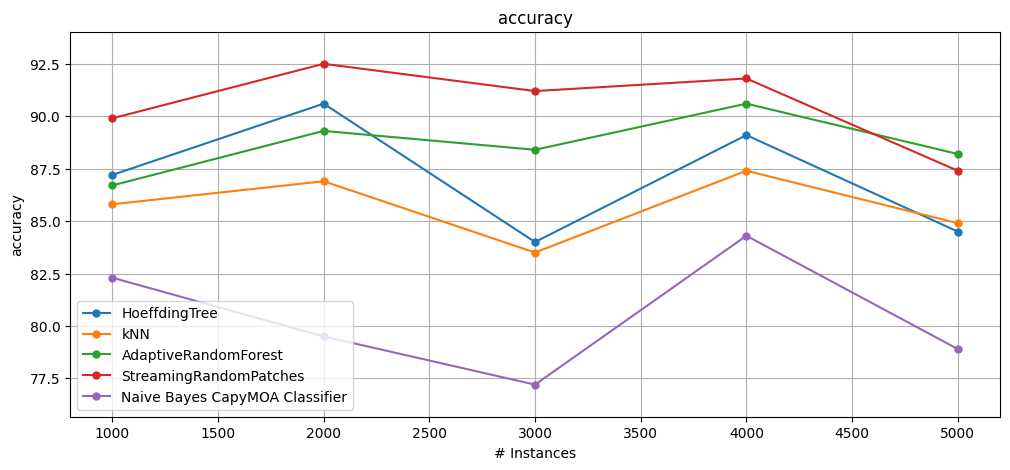

In [5]:
# Code to select the best performing model
schema = stream.get_schema()
ht = HoeffdingTree(schema)
knn = KNN(schema)
arf = AdaptiveRandomForestClassifier(schema, ensemble_size=5)
srp = StreamingRandomPatches(schema, ensemble_size=5)
nb = NaiveBayes(schema)
model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, 1000, 5000)
plot_windowed_results(*all_res.values(), metric="accuracy")

## 9.2 AutoML

The following example shows how to use the AutoClass algorithm using CapyMOA.

* ``base_classifiers`` is a list of classifier class types that will be candidates
  for the AutoML algorithm. The AutoML algorithm will select the best classifier
  based on its performance on the stream.

* ``configuration_json`` is a json file that contains the configuration for the
  AutoML algorithm. An example of the configuration file is shown below:


*Maroua Bahri, Nikolaos Georgantas. Autoclass: Automl for data stream
classification. In BigData, IEEE, 2023. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10386362*

In [10]:
with open("./settings_autoclass.json", "r") as f:
    settings = f.read()
    print(settings)

{

  "windowSize" :  1000,
  "ensembleSize" : 10,
  "newConfigurations" : 10,
  "keepCurrentModel" : true,
  "lambda" : 0.05,
  "preventAlgorithmDeath" : true,
  "keepGlobalIncumbent" : true,
  "keepAlgorithmIncumbents" : true,
  "keepInitialConfigurations" : true,
  "useTestEnsemble" : true,
  "resetProbability" : 0.01,
  "numberOfCores" : 1,
  "performanceMeasureMaximisation": true,

  "algorithms": [
    {
      "algorithm": "moa.classifiers.lazy.kNN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.trees.HoeffdingTree",
      "parameters": [
        {"parameter": "g", "type":"integer", "value":200, "range":[10, 200]},
       {"parameter": "c", "type":"float", "value":0.01, "range":[0, 1]}
      ]
    }
  ,
    {
      "algorithm": "moa.classifiers.lazy.kNNwithPAWandADWIN",
      "parameters": [
        {"parameter": "k", "type":"integer", "value":10, "range":[2,30]}
      ]
  

In [ ]:
max_instances = 20000
window_size = 2500

schema = stream.get_schema()
autoclass = AutoClass(
    schema=schema,
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)
results_autoclass = prequential_evaluation(
    stream=stream,
    learner=autoclass,
    window_size=window_size,
    max_instances=max_instances,
)
print_summary("AutoClass", results_autoclass)

AutoClass  Cumulative accuracy = 88.15, wall-clock time: 41.809


We compare the performance of the AutoML algorithm against basic
classifiers:

HT         Cumulative accuracy = 85.61, wall-clock time: 0.293
HAT        Cumulative accuracy = 87.08, wall-clock time: 0.207
KNN        Cumulative accuracy = 85.47, wall-clock time: 1.893
NB         Cumulative accuracy = 77.23, wall-clock time: 0.169


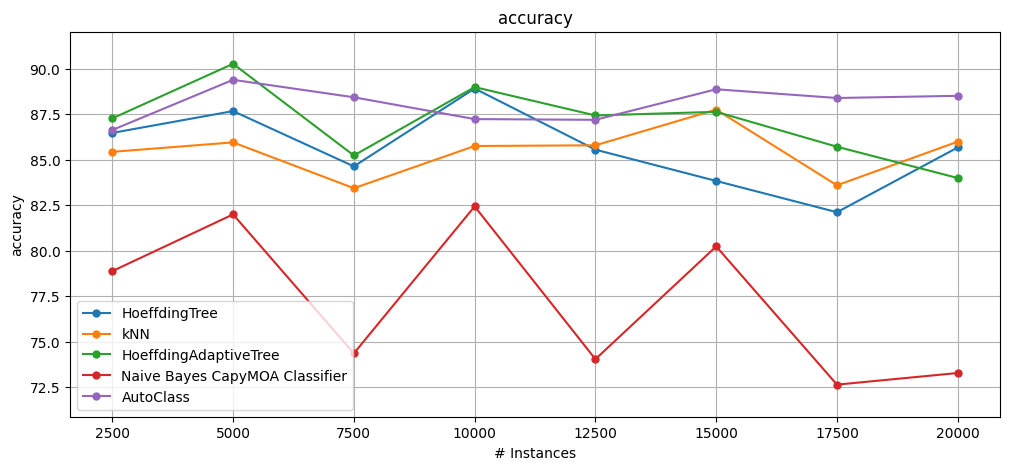

In [8]:
ht = HoeffdingTree(schema)
hat = HoeffdingAdaptiveTree(schema)
knn = KNN(schema)
nb = NaiveBayes(schema)

results_ht = prequential_evaluation(
    stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    stream, nb, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## 9.3 AutoML with Concept Drift

We test the same algorithms on a data stream with simulated concept drift:

HT         Cumulative accuracy = 78.82, wall-clock time: 0.316
HAT        Cumulative accuracy = 78.24, wall-clock time: 0.287
KNN        Cumulative accuracy = 67.14, wall-clock time: 5.484
NB         Cumulative accuracy = 60.29, wall-clock time: 0.114
AutoClass  Cumulative accuracy = 85.27, wall-clock time: 74.773


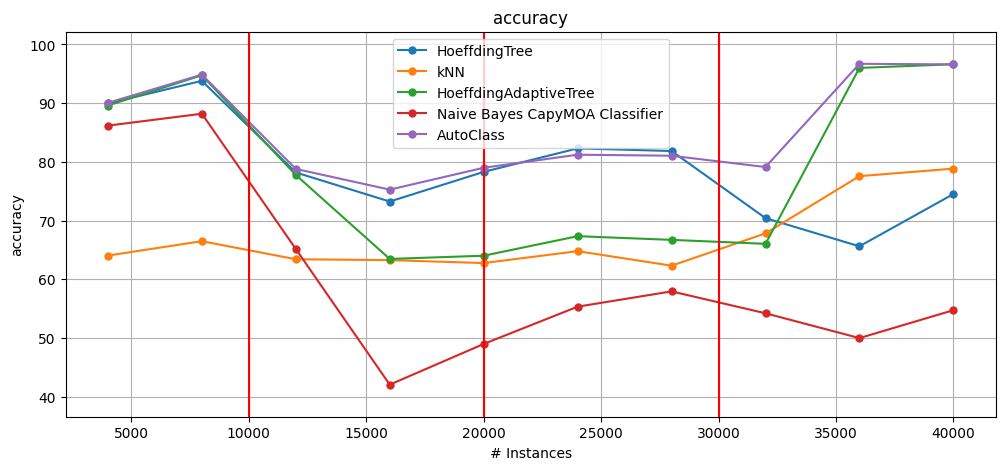

In [9]:
from capymoa.evaluation import prequential_evaluation
from capymoa.automl import AutoClass

max_instances = 40000
window_size = 4000

ht = HoeffdingTree(schema=drift_stream.get_schema())
hat = HoeffdingAdaptiveTree(schema=drift_stream.get_schema())
knn = KNN(schema=drift_stream.get_schema())
nb = NaiveBayes(schema=drift_stream.get_schema())
autoclass = AutoClass(
    schema=drift_stream.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)

results_ht = prequential_evaluation(
    drift_stream, ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    drift_stream, hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    drift_stream, knn, window_size=window_size, max_instances=max_instances
)
results_nb = prequential_evaluation(
    drift_stream, nb, window_size=window_size, max_instances=max_instances
)
results_autoclass = prequential_evaluation(
    drift_stream, autoclass, window_size=window_size, max_instances=max_instances
)

print_summary("HT", results_ht)
print_summary("HAT", results_hat)
print_summary("KNN", results_knn)
print_summary("NB", results_nb)
print_summary("AutoClass", results_autoclass)
plot_windowed_results(
    results_ht,
    results_knn,
    results_hat,
    results_nb,
    results_autoclass,
    metric="accuracy",
)

## 9.4 Analysis of further AutoML methods

### **Bandit Classifier**

It is a model selection for classification in streaming scenarios.


Each model is associated with an arm. At each train call, the policy decides which arm/model to pull.
The reward is the performance of the model on the provided sample. The predict and predict_proba
methods use the current best model.

### **Successive Halving Classifier**

The algorithm progressively eliminates poorly performing models while allocating more resources to promising ones.

Successive halving is a method for performing model selection without having to train each model on all the dataset.
At certain points in time (called "rungs"), the worst performing models will be discarded and the best ones
will keep competing between each other. The rung values are designed so that at most 'budget' model updates
will be performed in total.

### Testing whether SuccessiveHalvingClassifier and BanditClassifier work correctly

In [ ]:
f = io.StringIO()

def test_successive_halving_and_bandit(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Test SuccessiveHalving and BanditClassifier for parameter optimization of a single model type."""
    print("\n" + "="*80)
    print("TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 2

    # Create a wide range of HoeffdingTree configurations with different parameters
    ht_models = []

    # Test different grace periods
    for grace_period in [50, 100, 200, 300, 400]:
        # Test different split confidences
        for confidence in [0.001, 0.01, 0.05, 0.1, 0.2]:
            # Test different tie thresholds
            for tie_threshold in [0.05, 0.1, 0.2]:
                ht_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence, tie_threshold=tie_threshold))

    print(f"Created {len(ht_models)} different HoeffdingTree configurations")

    # Use SuccessiveHalving to find the best HoeffdingTree configuration
    with contextlib.redirect_stdout(f): 
        shc_ht = SuccessiveHalvingClassifier(schema=schema, base_classifiers=ht_models, budget=budget, eta=2.0, min_models=1, verbose=False)

    # Use BanditClassifier to find the best HoeffdingTree configuration
    bandit_ht = BanditClassifier(schema=schema, base_classifiers=ht_models, metric="accuracy", policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150), verbose=False)

    # Default HoeffdingTree for comparison
    default_ht = HoeffdingTree(schema=schema)

    print("\nRunning prequential evaluation...")
    results_shc_ht = prequential_evaluation(
        stream=stream, learner=shc_ht, window_size=window_size, max_instances=max_instances
    )
    results_bandit_ht = prequential_evaluation(
        stream=stream, learner=bandit_ht, window_size=window_size, max_instances=max_instances
    )
    results_default_ht = prequential_evaluation(
        stream=stream, learner=default_ht, window_size=window_size, max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[SuccessiveHalving with {len(ht_models)} HT configs] Accuracy = {results_shc_ht.accuracy():.3f}, "f"Time: {results_shc_ht.wallclock():.3f}s")
    print(f"[BanditClassifier with {len(ht_models)} HT configs] Accuracy = {results_bandit_ht.accuracy():.3f}, "f"Time: {results_bandit_ht.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_default_ht.accuracy():.3f}, "f"Time: {results_default_ht.wallclock():.3f}s")

    # Calculate improvements
    improvement_shc = (results_shc_ht.accuracy() - results_default_ht.accuracy())
    improvement_bandit = (results_bandit_ht.accuracy() - results_default_ht.accuracy())
    print("Improvement over default parameters:")
    print(f"SuccessiveHalving: {improvement_shc:.2f}% absolute")
    print(f"BanditClassifier: {improvement_bandit:.2f}% absolute")

    # Plot results
    plot_windowed_results(results_shc_ht, results_bandit_ht, results_default_ht, metric="accuracy")

    # Display final model info
    model_info_shc = shc_ht.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")


TESTING SUCCESSIVE HALVING AND BANDIT CLASSIFIER FOR PARAMETER OPTIMIZATION
Created 75 different HoeffdingTree configurations

Running prequential evaluation...

Evaluation Results:
[SuccessiveHalving with 75 HT configs] Accuracy = 87.225, Time: 149.803s
[BanditClassifier with 75 HT configs] Accuracy = 83.720, Time: 79.002s
[Default HoeffdingTree] Accuracy = 85.615, Time: 0.158s
Improvement over default parameters:
SuccessiveHalving: 1.61% absolute
BanditClassifier: -1.89% absolute

Successive Halving Final Status:
Active models: 1 / 75
Total rungs: 7
Budget used: 39999 / 40000


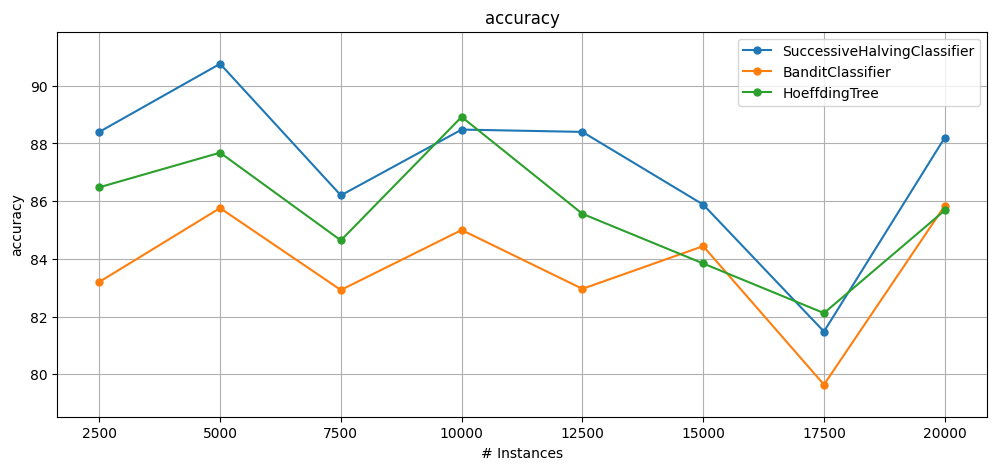

In [11]:
stream = Electricity()
max_instances = 20000
window_size = 2500
budget=max_instances*2

test_successive_halving_and_bandit(stream, max_instances=max_instances, window_size=window_size, budget=budget)


In the initial test, SuccessiveHalvingClassifier delivers the best accuracy (87.2%, +1.6% over HoeffdingTree) but takes 153s, while BanditClassifier is much faster (86s) with similar accuracy to the default, trading precision for speed. 

The results highlight a clear accuracy–time trade-off between thorough configuration search and faster, less precise optimization.

## 9.5 Comparing AutoClass with SuccessiveHalving and BanditClassifier

In [12]:
def base_models_configuration():
    # Create base classifiers with same parameters for SuccessiveHalving and BanditClassifier
    base_models = []

    # Add Hoeffding Trees
    for grace_period in [100, 200, 300, 400]:
        for confidence in [0.001, 0.01, 0.05, 0.1]:
            base_models.append(HoeffdingTree(schema=schema, grace_period=grace_period, confidence=confidence))

    # Add KNN variations
    for k in [3, 5, 10, 15, 20]:
        base_models.append(KNN(schema=schema, k=k))

    # Add Random Forest models
    for ensemble_size in [80, 100, 120]:
        base_models.append(AdaptiveRandomForestClassifier(schema=schema, ensemble_size=ensemble_size))

    # Add Hoeffding Adaptive Trees
    for grace_period in [100, 200, 300]:
        base_models.append(HoeffdingAdaptiveTree(schema=schema, grace_period=grace_period))

    # Add Leveraging Bagging models
    for ensemble_size in [60, 80, 100]:
        base_models.append(LeveragingBagging(schema=schema, ensemble_size=ensemble_size))

    # Add Streaming Random Patches
    for ensemble_size in [60, 80, 100]:
        base_models.append(StreamingRandomPatches(schema=schema, ensemble_size=ensemble_size))

    return base_models

In [15]:
def test_autoclass_vs_successive_halving(stream, max_instances=20000, window_size=2500, budget=None, bandit_eps=0.1):
    """Compare AutoClass with enhanced configuration against SuccessiveHalvingClassifier and BanditClassifier."""
    print("\n" + "="*80)
    print("COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER")
    print("="*80)

    schema = stream.get_schema()
    if budget is None:
        budget = max_instances * 3

    # Initialize AutoClass with the enhanced configuration
    autoclass_enhanced = AutoClass(schema=schema, configuration_json="./enhanced_autoclass_config.json", base_classifiers=[KNN, HoeffdingTree, HoeffdingAdaptiveTree, AdaptiveRandomForestClassifier, LeveragingBagging, StreamingRandomPatches])

    # Create base classifiers with same parameters for SuccessiveHalving and BanditClassifier
    base_models = base_models_configuration()

    print(f"Total number of model configurations: {len(base_models)}")

    # Create the SuccessiveHalvingClassifier
    with contextlib.redirect_stdout(f): 
        shc_direct = SuccessiveHalvingClassifier(schema=schema, base_classifiers=base_models, budget=budget, eta=2.0, min_models=2, verbose=True)

    # Create the BanditClassifier
    bandit_clf = BanditClassifier(schema=schema, base_classifiers=base_models, metric="accuracy", policy=EpsilonGreedy(epsilon=bandit_eps, burn_in=150), verbose=True)

    # Initialize default models for comparison
    print("\nInitializing default models for comparison...")
    default_ht = HoeffdingTree(schema=schema)
    default_knn = KNN(schema=schema)
    default_arf = AdaptiveRandomForestClassifier(schema=schema)
    default_hat = HoeffdingAdaptiveTree(schema=schema)
    default_lb = LeveragingBagging(schema=schema)
    default_srp = StreamingRandomPatches(schema=schema)

    print("\nRunning prequential evaluation...")

    # Evaluate all approaches
    results_autoclass_enhanced = prequential_evaluation(
        stream=stream, learner=autoclass_enhanced, window_size=window_size, max_instances=max_instances
    )
    results_shc = prequential_evaluation(
        stream=stream, learner=shc_direct, window_size=window_size, max_instances=max_instances
    )
    results_bandit = prequential_evaluation(
        stream=stream,learner=bandit_clf, window_size=window_size, max_instances=max_instances
    )

    # Evaluate default models
    print("\nEvaluating default models...")
    results_ht = prequential_evaluation(
        stream=stream, learner=default_ht, window_size=window_size, max_instances=max_instances
    )
    results_knn = prequential_evaluation(
        stream=stream, learner=default_knn, window_size=window_size, max_instances=max_instances
    )
    results_arf = prequential_evaluation(
        stream=stream, learner=default_arf, window_size=window_size, max_instances=max_instances
    )
    results_hat = prequential_evaluation(
        stream=stream, learner=default_hat, window_size=window_size, max_instances=max_instances
    )
    results_lb = prequential_evaluation(
        stream=stream, learner=default_lb, window_size=window_size, max_instances=max_instances
    )
    results_srp = prequential_evaluation(
        stream=stream, learner=default_srp, window_size=window_size, max_instances=max_instances
    )

    # Print results
    print("\nEvaluation Results:")
    print(f"[Enhanced AutoClass] Accuracy = {results_autoclass_enhanced.accuracy():.3f}, "f"Time: {results_autoclass_enhanced.wallclock():.3f}s")
    print(f"[SuccessiveHalving] Accuracy = {results_shc.accuracy():.3f}, "f"Time: {results_shc.wallclock():.3f}s")
    print(f"[BanditClassifier] Accuracy = {results_bandit.accuracy():.3f}, "f"Time: {results_bandit.wallclock():.3f}s")
    print(f"[Default HoeffdingTree] Accuracy = {results_ht.accuracy():.3f}, "f"Time: {results_ht.wallclock():.3f}s")
    print(f"[Default KNN] Accuracy = {results_knn.accuracy():.3f}, "f"Time: {results_knn.wallclock():.3f}s")
    print(f"[Default AdaptiveRandomForest] Accuracy = {results_arf.accuracy():.3f}, "f"Time: {results_arf.wallclock():.3f}s")
    print(f"[Default HoeffdingAdaptiveTree] Accuracy = {results_hat.accuracy():.3f}, "f"Time: {results_hat.wallclock():.3f}s")
    print(f"[Default LeveragingBagging] Accuracy = {results_lb.accuracy():.3f}, "f"Time: {results_lb.wallclock():.3f}s")
    print(f"[Default StreamingRandomPatches] Accuracy = {results_srp.accuracy():.3f}, "f"Time: {results_srp.wallclock():.3f}s")

    # Plot results
    plot_windowed_results(
        results_autoclass_enhanced, results_shc, results_bandit, results_ht, results_knn, results_arf, results_hat, results_lb, results_srp, metric="accuracy"
    )

    # Display final model info for SuccessiveHalving
    model_info_shc = shc_direct.get_model_info()
    print("\nSuccessive Halving Final Status:")
    print(f"Active models: {model_info_shc['active_models']} / {model_info_shc['total_models']}")
    print(f"Total rungs: {model_info_shc['current_rung']}")
    print(f"Budget used: {model_info_shc['budget_used']} / {model_info_shc['total_budget']}")

    # Display final model info for BanditClassifier
    model_info_bandit = bandit_clf.get_model_info()
    print("\nBandit Classifier Final Status:")
    print(f"Total models: {model_info_bandit['total_models']}")
    print(f"Best model accuracy: {model_info_bandit['best_model_accuracy']:.4f}")

    print("\nTop performing models:")
    print("SuccessiveHalving:")
    for i, model_info in enumerate(model_info_shc['top_models']):
        print(f"  {i+1}. {model_info['model']} - Accuracy: {model_info['accuracy']:.4f}")

### Test on Electricity Stream


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Total number of model configurations: 33
Using 33 provided base classifiers

Initializing default models for comparison...

Running prequential evaluation...
[Rung 1]	16 models removed	17 models left	75 instances per model	budget used: 2475	budget left: 12525	best accuracy: 90.6667
Top models:
  1. StreamingRandomPatches - Accuracy: 90.6667
  2. StreamingRandomPatches - Accuracy: 90.6667
  3. StreamingRandomPatches - Accuracy: 89.3333
[Rung 2]	8 models removed	9 models left	147 instances per model	budget used: 4974	budget left: 10026	best accuracy: 91.4414
Top models:
  1. StreamingRandomPatches - Accuracy: 91.4414
  2. StreamingRandomPatches - Accuracy: 90.9910
  3. StreamingRandomPatches - Accuracy: 90.9910
[Rung 3]	4 models removed	5 models left	278 instances per model	budget used: 7476	budget left: 7524	best accuracy: 89.2000
Top models:
  1. StreamingRandomPatches - Accuracy: 89.2000
  2. StreamingRandomPa

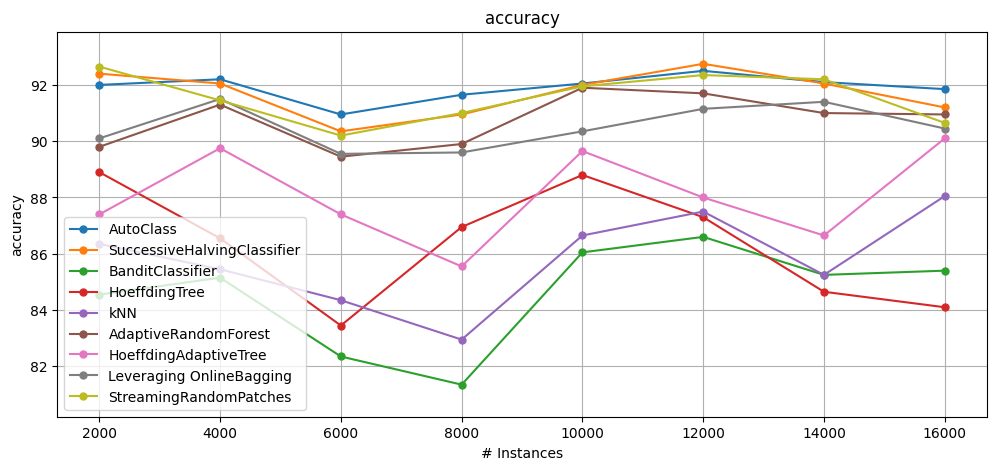

In [16]:
stream = Electricity()
max_instances = 15000
window_size = 2000
budget=max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

On Electricity, AutoClass achieves the highest accuracy (91.8%) but is slowest (438s). 

SuccessiveHalvingClassifier nearly matches it (91.6%) while running 40% faster, offering the best balance. 

BanditClassifier (84.5%, 75s) is fastest but underperforms, even below the default HoeffdingTree (86.2%). 

Overall, thorough model selection proves more effective here, with SuccessiveHalving striking the optimal trade-off.

### Test on RBFm_100k Stream


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Total number of model configurations: 33
Using 33 provided base classifiers

Initializing default models for comparison...

Running prequential evaluation...
[Rung 1]	16 models removed	17 models left	75 instances per model	budget used: 2475	budget left: 12525	best accuracy: 48.0000
Top models:
  1. kNN - Accuracy: 48.0000
  2. HoeffdingAdaptiveTree - Accuracy: 45.3333
  3. HoeffdingAdaptiveTree - Accuracy: 45.3333
[Rung 2]	8 models removed	9 models left	147 instances per model	budget used: 4974	budget left: 10026	best accuracy: 66.6667
Top models:
  1. kNN - Accuracy: 66.6667
  2. HoeffdingAdaptiveTree - Accuracy: 44.5946
  3. HoeffdingAdaptiveTree - Accuracy: 44.5946
[Rung 3]	4 models removed	5 models left	278 instances per model	budget used: 7476	budget left: 7524	best accuracy: 79.8000
Top models:
  1. kNN - Accuracy: 79.8000
  2. StreamingRandomPatches - Accuracy: 51.6000
  3. StreamingRandomPatches - Accur

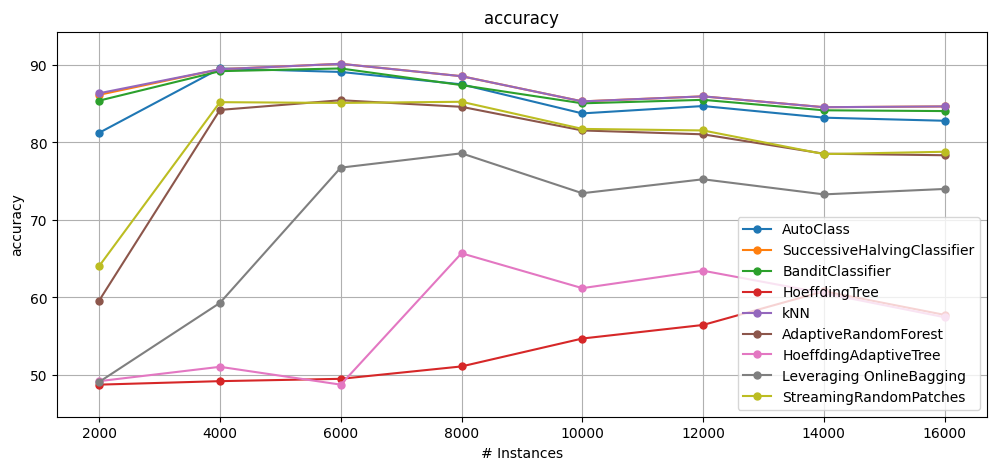

In [17]:
stream = RBFm_100k()
max_instances = 15000
window_size = 2000
budget = max_instances
test_autoclass_vs_successive_halving(stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

On RBFm_100k, SuccessiveHalvingClassifier achieves the best accuracy (87.0%) while being 2x faster than AutoClass, making it the most favorable trade-off.
 
BanditClassifier (86.8%, 126s) is the fastest, with only a 0.2% drop vs. SuccessiveHalving, while AutoClass lags behind (85.4%, 494s). 

All methods vastly outperform the default HoeffdingTree (53.2%), highlighting the impact of parameter optimization.

### Test on custom stream with drift


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Total number of model configurations: 33
Using 33 provided base classifiers

Initializing default models for comparison...

Running prequential evaluation...
[Rung 1]	16 models removed	17 models left	227 instances per model	budget used: 7491	budget left: 37509	best accuracy: 81.0573
Top models:
  1. kNN - Accuracy: 81.0573
  2. kNN - Accuracy: 81.0573
  3. kNN - Accuracy: 80.1762
[Rung 2]	8 models removed	9 models left	441 instances per model	budget used: 14988	budget left: 30012	best accuracy: 82.9341
Top models:
  1. kNN - Accuracy: 82.9341
  2. HoeffdingAdaptiveTree - Accuracy: 82.7844
  3. HoeffdingAdaptiveTree - Accuracy: 82.7844
[Rung 3]	4 models removed	5 models left	833 instances per model	budget used: 22485	budget left: 22515	best accuracy: 85.0100
Top models:
  1. kNN - Accuracy: 85.0100
  2. kNN - Accuracy: 84.5436
  3. kNN - Accuracy: 84.4104
[Rung 4]	2 models removed	3 models left	1501 instances pe

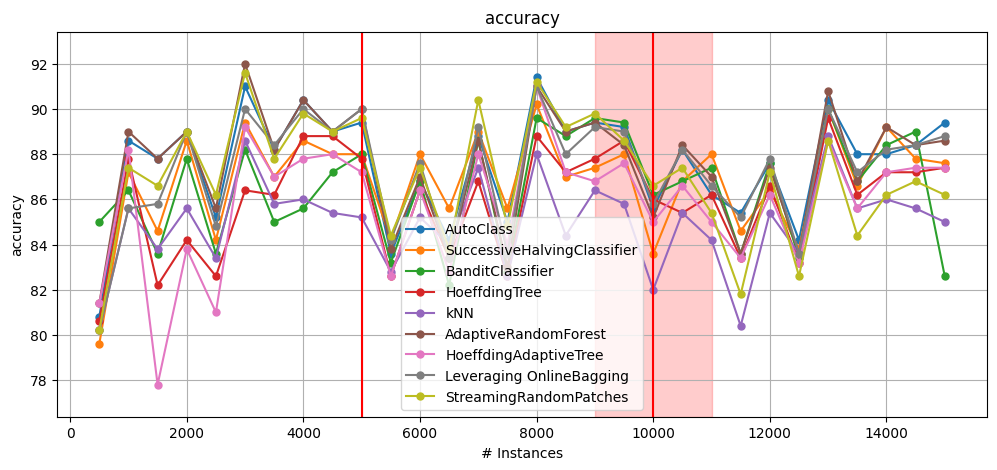

In [18]:
window_size=500
max_instances=15000
budget=max_instances*3
drift_stream = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        SEA(function=1),
    ]
)
test_autoclass_vs_successive_halving(drift_stream, window_size=window_size, max_instances=max_instances, budget=budget, bandit_eps=0.3)

On the drift stream, Enhanced AutoClass reaches the top accuracy (87.68%) but is the slowest (226s), while BanditClassifier (86.11%, 84s) offers the best efficiency-accuracy balance, being over 2x faster than SuccessiveHalving with only a 0.7% drop. 

AdaptiveRandomForest (87.5%) shows that strong default ensembles can rival AutoML methods.


COMPARING AUTOCLASS WITH CONFIG, SUCCESSIVE HALVING, AND BANDIT CLASSIFIER
Total number of model configurations: 33
Using 33 provided base classifiers

Initializing default models for comparison...

Running prequential evaluation...
[Rung 1]	16 models removed	17 models left	181 instances per model	budget used: 5973	budget left: 30027	best accuracy: 71.2707
Top models:
  1. AdaptiveRandomForest - Accuracy: 71.2707
  2. AdaptiveRandomForest - Accuracy: 70.7182
  3. AdaptiveRandomForest - Accuracy: 70.1657
[Rung 2]	8 models removed	9 models left	353 instances per model	budget used: 11974	budget left: 24026	best accuracy: 74.1573
Top models:
  1. Leveraging OnlineBagging - Accuracy: 74.1573
  2. Leveraging OnlineBagging - Accuracy: 73.7828
  3. Leveraging OnlineBagging - Accuracy: 73.2210
[Rung 3]	4 models removed	5 models left	667 instances per model	budget used: 17977	budget left: 18023	best accuracy: 76.7694
Top models:
  1. Leveraging OnlineBagging - Accuracy: 76.7694
  2. Leveraging 

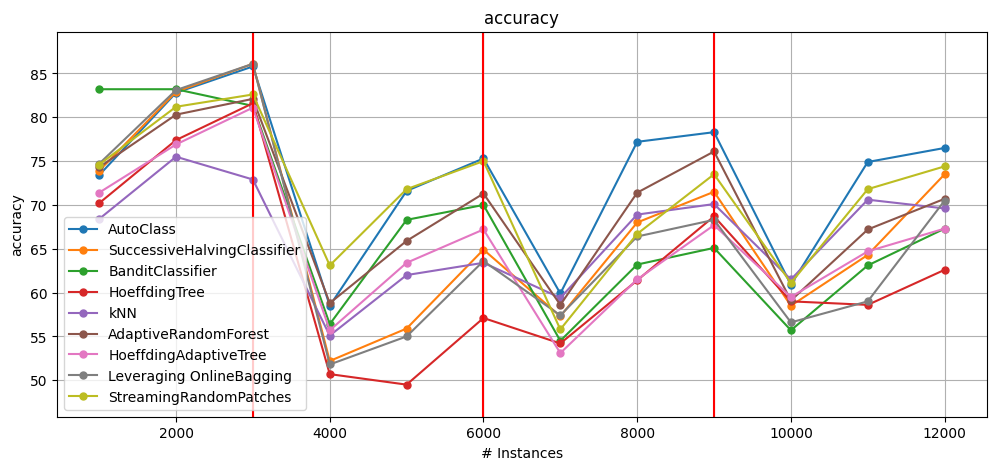

In [19]:
concept_length = 3000
max_instances = concept_length * 4
window_size = 1000

# Create a stream with multiple concept drifts
drift_stream = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=concept_length),
        RandomTreeGenerator(tree_random_seed=2),
        AbruptDrift(position=concept_length * 2),
        RandomTreeGenerator(tree_random_seed=3),
        AbruptDrift(position=concept_length * 3),
        RandomTreeGenerator(tree_random_seed=4),
    ]
)

test_autoclass_vs_successive_halving(drift_stream, max_instances, window_size, budget=max_instances*3, bandit_eps=0.3)

On the custom stream with concept drift, Enhanced AutoClass achieves the highest accuracy (72.1%) but at a much higher temporal cost (776s vs 213s/106s), showing a clear trade-off between performance and efficiency. 

Bandit and SuccessiveHalving reach similar accuracy (~67%) with Bandit being twice as fast, while StreamingRandomPatches (71.0%) highlights the strength of ensembles under drift.

### Overall Analysis

Across tested streams, the three model selection approaches show consistent accuracy–efficiency trade-offs:

- AutoClass: highest (or near-highest) accuracy, especially under concept drift, but 2–7× slower than BanditClassifier.

- SuccessiveHalvingClassifier: accuracy within 0.5–5% of AutoClass, but 40–70% faster; strong on Electricity and RBFm_100k.

- BanditClassifier: fastest (40–50% faster than SuccessiveHalving, 70–85% faster than AutoClass) but less accurate (–0.2–7%); weaker on Electricity, competitive on RBFm_100k.

Guidelines based on these results:

1. Max accuracy & high resources → AutoClass.

2. Balance accuracy/efficiency → SuccessiveHalvingClassifier.

3. Time/resource-constrained → BanditClassifier.